In [12]:
import pandas as pd
import numpy as np
import pickle
import sys

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/mpra/utils")

from mlp import *
from misc import dotdict

import sklearn.model_selection
import sklearn.pipeline

%load_ext autoreload
%autoreload 2

In [13]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/'

In [14]:
input_params = dotdict({})

input_params.data_tsv = data_dir + 'variants/selected/variants_snp.tsv'
input_params.split = 'gnomAD'
input_params.embeddings = data_dir + 'variants/embeddings/stspace/predictions.pickle'

In [15]:
data_df = pd.read_csv(input_params.data_tsv, sep='\t') 

data_df = data_df[data_df.split==input_params.split] #choose given data subset, attention to the lowercase!

In [16]:
with open(input_params.embeddings, 'rb') as f:
    data = pickle.load(f)
    seq_names, embeddings = data['seq_names'], data['embeddings']
    embeddings_df = []
    for idx in range(0,len(embeddings),2):
        assert seq_names[idx]==seq_names[idx+1].replace('alt','ref')
        emb_ref, emb_alt = embeddings[idx], embeddings[idx+1]
        varname = seq_names[idx].replace('_ref','').split('_')
        embeddings_df.append((varname[0],int(varname[1]),varname[2],varname[3],emb_ref,emb_alt))
    embeddings_df = pd.DataFrame(embeddings_df, columns=['chrom','pos','ref','alt','emb_ref','emb_alt'])

data_df = data_df.merge(embeddings_df, how='left')

In [17]:
data_df.reset_index(drop=True, inplace=True)

In [18]:
X = data_df[['emb_ref','emb_alt']].values
X = np.array(X.tolist()).reshape(len(X),-1) #contatenate ref and alt embeddings for each variant

y = data_df['label'].values

In [20]:
skf = sklearn.model_selection.StratifiedKFold(n_splits=10)

all_res = []

for train_idx, test_idx in skf.split(X,y):
    
    X_train, y_train, X_test, y_test = X[train_idx],y[train_idx], X[test_idx],y[test_idx]

    shuffled_idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[shuffled_idx], y_train[shuffled_idx]

    all_res.extend(list(zip(test_idx,y_test)))

In [27]:

pipe = sklearn.pipeline.Pipeline(steps=[
         ('StandardScaler', sklearn.preprocessing.StandardScaler()),
         ('MLP', MLPClassifier(hidden_layer_sizes=(1024,128,32,), 
                 p_dropout=0.5, weight_decay=0, lr=1e-4,
                batch_size = 1024, N_epochs = 300))
        ])

In [31]:
#%%timeit -n 1 -r 1
pipe.fit(X_train, y_train)

/home/icb/sergey.vilov/miniconda3/envs/ntrans/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Pipeline(steps=[('StandardScaler', StandardScaler()),
                ('MLP', MLPClassifier(lr=0.0001))])

In [32]:
pipe.score(X_test,y_test)

0.5727909999999999

In [25]:
t,v=zip(*M.history_)

(0.5, 0.7)

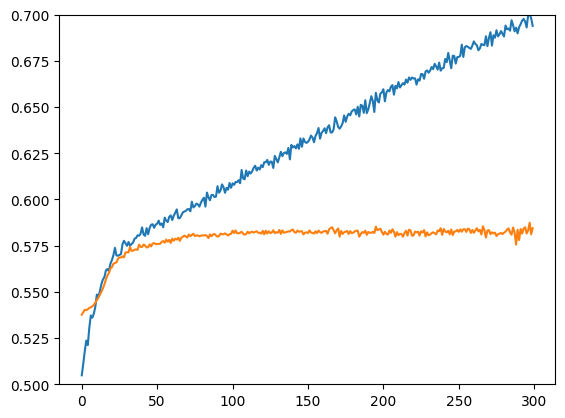

In [26]:
import matplotlib.pyplot as plt


plt.plot(t)
plt.plot(v)
plt.ylim([0.5,0.7])